Tutorial: Task Dependency Management
====================================

Objective:

> Learning how ML workflows can be representated using acyclic task graphs, how to construct them and how they are essential to portability.

Principles:

1. Workflows are represented using dependencies of their tasks modeled by acyclic graphs.
2. The actual task graph can be displayed when selecting the `graphviz` runner.
3. Individual tasks are implemented using _Actors_ which can be _stateless_ or _stateful_.
4. _Train_ versus _Apply_ modes are represented using tightly coupled but distinct (in the case of stateful nodes) task graphs.
5. Operators are reusable components that facilitate the construction of a task graph topology.
6. Operator composition is a non-linear process combining two operators to produce more complex task graph topology.
7. Task graphs can be executed using different runners.

## Paradigm Explained

* conventional programming involves direct coding of the application logic using entities of the given language
  * difficult introspection
* task-based programming adds an extra layer on top breaking the logic into steps with defined dependencies  
* DAG
* scheduling, scalability, reusablity


### Runners

* Main Compute - Dask/Spark
* Alternative Runners - Graphviz, Pyfunc

In [1]:
from forml import project
from forml.pipeline import payload
from dummycatalog import Foo

SOURCE = project.Source.query(Foo)
PIPELINE = payload.ToPandas()

SOURCE.bind(PIPELINE).launcher.apply()

,Timestamp,Label,Level,Value,Bar
0,2021-05-05 03:12:19,1,Alpha,0.26,1
1,2021-05-11 11:27:50,0,Tango,0.94,3
2,2021-05-11 17:35:27,0,Zulu,0.57,4
3,2021-05-06 19:49:43,0,Uniform,0.69,2
4,2021-05-12 08:53:35,0,Xray,0.83,5
5,2021-05-12 22:06:04,0,Victor,0.61,6
6,2021-05-07 13:17:43,1,Echo,0.12,1
7,2021-05-13 16:25:18,0,Whiskey,0.78,3
8,2021-05-13 06:31:58,0,November,0.92,4
9,2021-05-08 15:48:20,0,Yankee,0.68,5


#### Spark

In [2]:
SOURCE.bind(PIPELINE).launcher(runner='spark').apply()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/23 14:32:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Timestamp,Label,Level,Value,Bar
0,2021-05-05 03:12:19,1,Alpha,0.26,1
1,2021-05-11 11:27:50,0,Tango,0.94,3
2,2021-05-11 17:35:27,0,Zulu,0.57,4
3,2021-05-06 19:49:43,0,Uniform,0.69,2
4,2021-05-12 08:53:35,0,Xray,0.83,5
5,2021-05-12 22:06:04,0,Victor,0.61,6
6,2021-05-07 13:17:43,1,Echo,0.12,1
7,2021-05-13 16:25:18,0,Whiskey,0.78,3
8,2021-05-13 06:31:58,0,November,0.92,4
9,2021-05-08 15:48:20,0,Yankee,0.68,5


#### Workflow Visualization

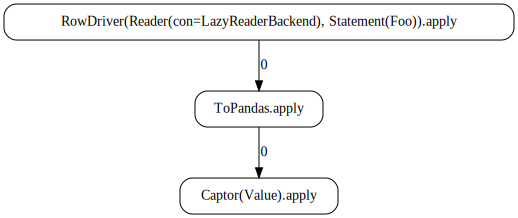

In [3]:
SOURCE.bind(PIPELINE).launcher(runner='graphviz').apply()

## Actors

Representing the unit of work within the workflow - the vertices in the task graph.

Connected using _input_ and _output_ [ports](https://docs.forml.io/en/latest/workflow/actor.html#ports).

* system vs application ports

implementing:
* native
* decorated

modes:
* train vs apply

Number of different ways to create an actor. We use the 

### Stateless Actor

In [4]:
import pandas
from forml.pipeline import wrap

@wrap.Actor.apply
def LowerActor(data: pandas.DataFrame, *, column: str) -> pandas.Series:
    return data[column].apply(lambda v: v.lower())

In [5]:
df = pandas.DataFrame({'greetings': ['Hello', 'Hallo', 'Hola', 'Ola', 'Ciao']})

lower_actor = LowerActor(column='greetings')
lower_actor.apply(df)

0    hello
1    hallo
2     hola
3      ola
4     ciao
Name: greetings, dtype: object

#### Excercise: Write Actor Returning Ascii Code of Lower-cased First Letter

In [6]:
@wrap.Actor.apply
def OrdActor(data: pandas.DataFrame, *, column: str) -> pandas.Series:
    return data[column].apply(lambda v: ord(v[0].lower()))

In [7]:
ord_actor = OrdActor(column='greetings')
ord_actor.apply(df)

0    104
1    104
2    104
3    111
4     99
Name: greetings, dtype: int64

### Stateful Actor

In [8]:
import typing

@wrap.Actor.train
def CenterActor(state: typing.Optional[float], data: pandas.DataFrame, labels: pandas.Series, *, column: str) -> float:
    return data[column].mean()

@CenterActor.apply
def CenterActor(state: float, data: pandas.DataFrame, *, column: str) -> pandas.DataFrame:
    return data[column] - state

In [9]:
df = pandas.DataFrame({'rating': [0.3, 0.1, 0.7, 0.6, 0.4]})

center_actor = CenterActor(column='rating')
center_actor.train(df, None)
center_actor.apply(df)

0   -0.12
1   -0.32
2    0.28
3    0.18
4   -0.02
Name: rating, dtype: float64

## Operators

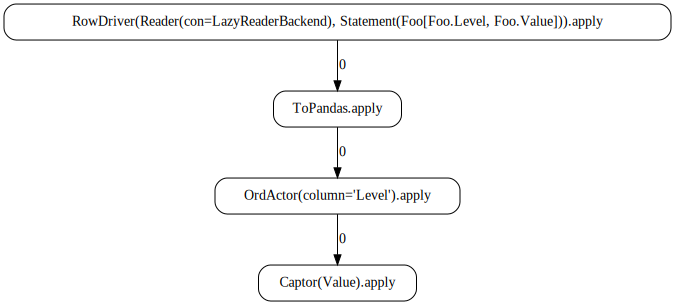

In [10]:
Ord = wrap.Operator.mapper(OrdActor)

SOURCE = project.Source.query(Foo.select(Foo.Level, Foo.Value), labels=Foo.Label) >> payload.ToPandas()
PIPELINE = Ord(column='Level')

SOURCE.bind(PIPELINE).launcher(runner='graphviz').apply()

### Decorated

#### Excercise: Write 

In [11]:
@wrap.Actor.train
def MinMax(state: typing.Optional[tuple[float, float]], data: pandas.DataFrame, labels: pandas.Series, *, column: str) -> tuple[float, float]:
    min_ = data[column].min()
    return min_, data[column].max() - min_

@wrap.Operator.mapper
@MinMax.apply
def MinMax(state: tuple[float, float], data: pandas.DataFrame, *, column: str) -> pandas.DataFrame:
    data[column] = (data[column] - state[0]) / state[1]
    return data

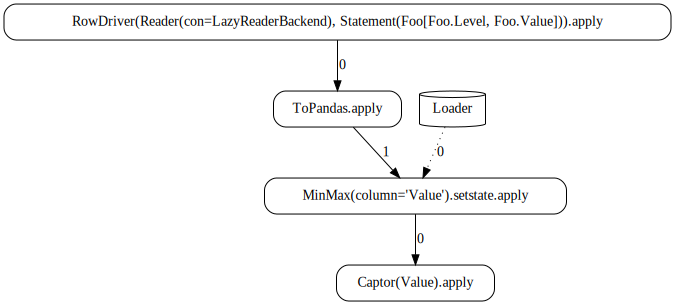

In [13]:
PIPELINE = MinMax(column='Value')

SOURCE.bind(PIPELINE).launcher(runner='graphviz').apply()

### Train-Apply Workflow Duality

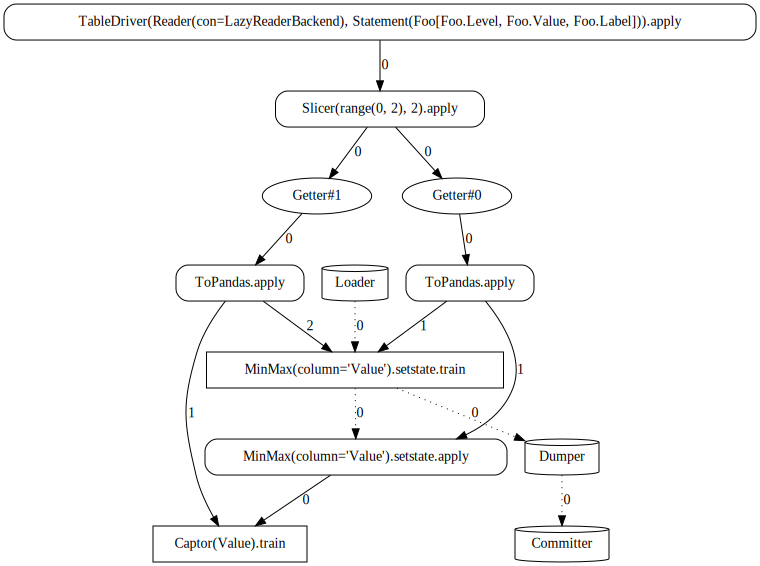

In [14]:
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

In [15]:
launcher = SOURCE.bind(PIPELINE).launcher(runner='dask')
launcher.train()
launcher.apply()

INFO: 2023-05-23 14:34:42,420: lazy: Loading Foo
INFO: 2023-05-23 14:34:44,536: lazy: Loading Foo


,Level,Value
0,Alpha,0.218391
1,Tango,1.000000
2,Zulu,0.574713
3,Uniform,0.712644
4,Xray,0.873563
5,Victor,0.620690
6,Echo,0.057471
7,Whiskey,0.816092
8,November,0.977011
9,Yankee,0.701149


### Library Operators

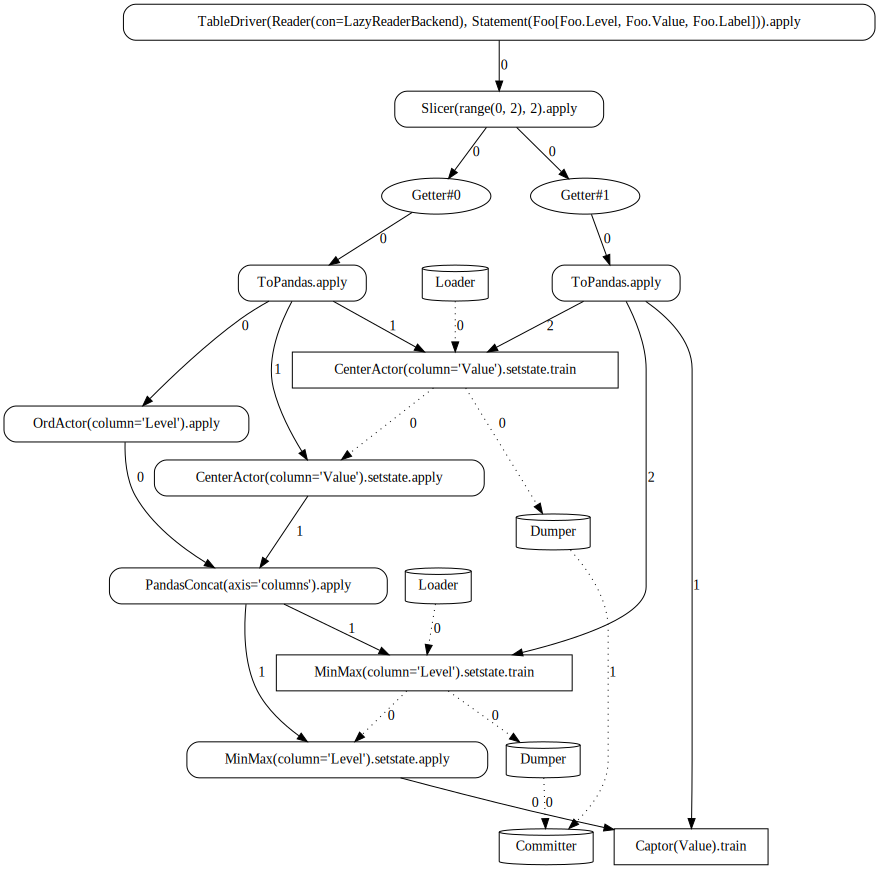

In [16]:
PIPELINE = payload.MapReduce(OrdActor.builder(column='Level'), CenterActor.builder(column='Value')) >> MinMax(column='Level')
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

In [17]:
launcher = SOURCE.bind(PIPELINE).launcher(runner='dask')
launcher.train()
launcher.apply()

,Level,Value
0,0.00,-0.3205
1,0.76,0.3595
2,1.00,-0.0105
3,0.80,0.1095
4,0.92,0.2495
5,0.84,0.0295
6,0.16,-0.4605
7,0.88,0.1995
8,0.52,0.3395
9,0.96,0.0995


### Implementing Custom Operator

In [18]:
from imblearn import over_sampling
from forml import flow


@wrap.Actor.apply
def OverSampler(features: pandas.DataFrame, labels: pandas.Series, *, random_state: typing.Optional[int] = None):
    """Stateless actor  with two input and two output ports for oversampling the features/labels of the minor class."""
    return over_sampling.RandomOverSampler(random_state=random_state).fit_resample(
        features, labels
    )


class Balancer(flow.Operator):
    """Balancer operator inserting the provided sampler into the ``train`` & ``label`` paths."""

    def __init__(self, sampler: flow.Builder = OverSampler.builder(random_state=42)):
        self._sampler = sampler

    def compose(self, scope: flow.Composable) -> flow.Trunk:
        left = scope.expand()
        sampler = flow.Worker(self._sampler, 2, 2)
        sampler[0].subscribe(left.train.publisher)
        new_features = flow.Future()
        new_features[0].subscribe(sampler[0])
        sampler[1].subscribe(left.label.publisher)
        new_labels = flow.Future()
        new_labels[0].subscribe(sampler[1])
        return left.use(
            train=left.train.extend(tail=new_features),
            label=left.label.extend(tail=new_labels),
        )

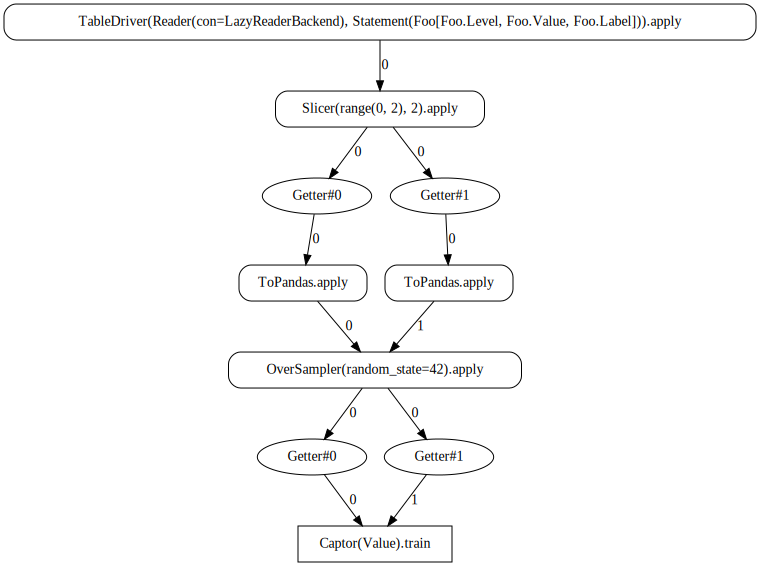

In [19]:
PIPELINE = Balancer()
SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()

In [20]:
SOURCE.bind(PIPELINE).launcher(runner='dask').train().labels.value_counts()

Label
1    14
0    14
Name: count, dtype: int64

### Operator Unit Testing

In [21]:
from forml import testing

class TestBalancer(testing.operator(Balancer)):
    """Balancer unit tests."""

    default_oversample = (
        testing.Case()
        .train([[1], [1], [0]], [1, 1, 0])
        .returns([[1], [1], [0], [0]], labels=[1, 1, 0, 0])
    )

In [22]:
import unittest
suite = unittest.TestSuite()
suite.addTest(TestBalancer('test_default_oversample'))

runner = unittest.TextTestRunner()
runner.run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 1.975s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

### Auto-wrapping 3rd-party Components

In [23]:
with wrap.importer():
    from sklearn.linear_model import LogisticRegression

isinstance(LogisticRegression(), flow.Operator)

True

Pipeline
--------

* Creating simple pipeline with an estimator
* Specifying Target Column
* Composition with an Estimator

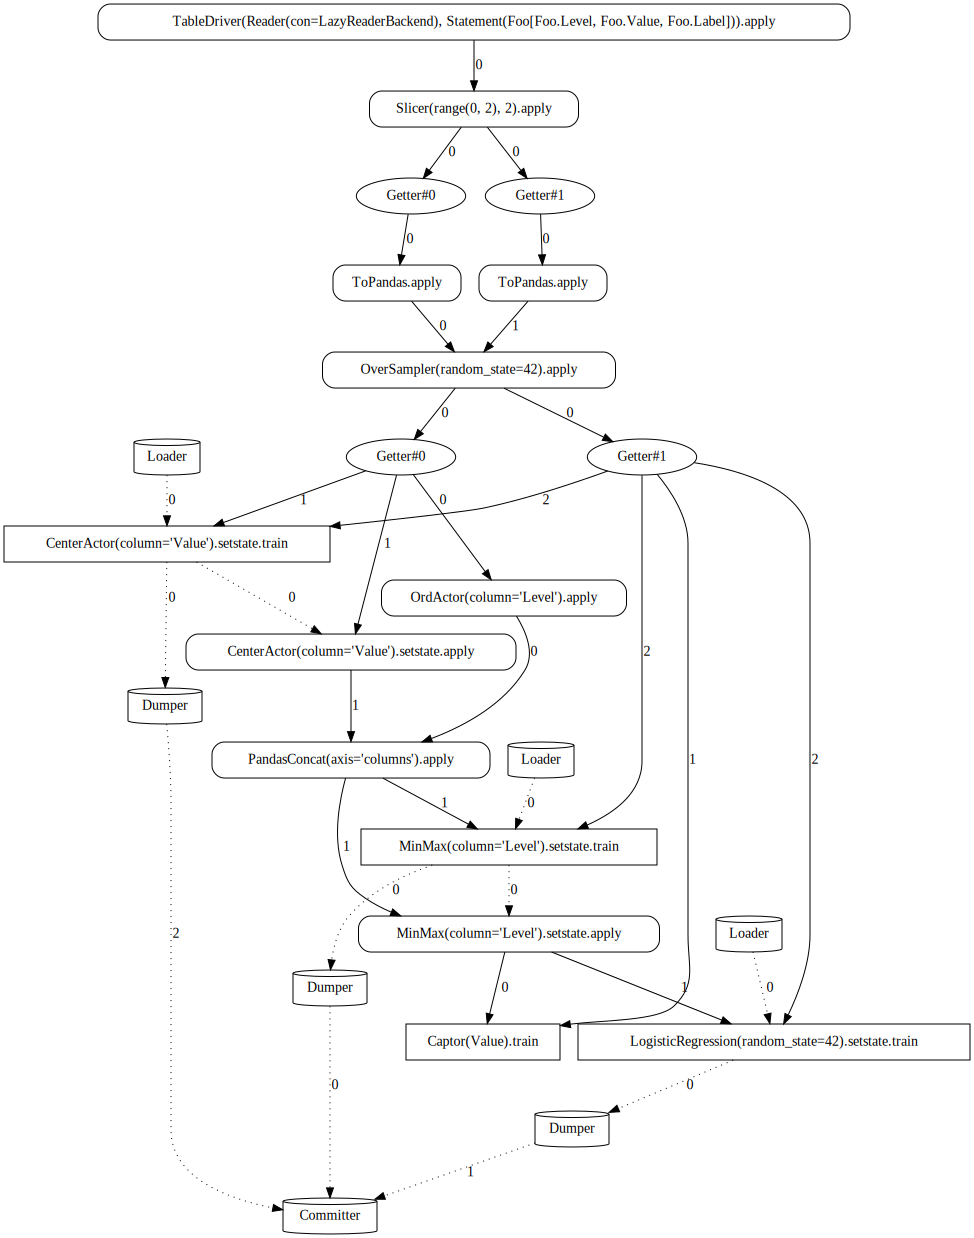

In [24]:
PIPELINE = Balancer() >> payload.MapReduce(OrdActor.builder(column='Level'), CenterActor.builder(column='Value')) >> MinMax(column='Level') >> LogisticRegression(random_state=42)

SOURCE.bind(PIPELINE).launcher(runner='graphviz').train()